# Прогнозирование заказов такси / Taxi orders prediction

В этом проекте по данным о зказах такси необходимо построить модель предсказывающую количество заказов такси на следующий час в период пиковой нагрузки. Заказчик требует метрику RMSE не больше 48.

----

In this project, using data on taxi orders, it is necessary to build a model that predicts the number of taxi orders for the next hour during a peak period. The customer requires an RMSE metric of no more than 48.

# Загрузка и ресемплирование данных / Data import and resampling

## Загрузка и первичное ознакомление / Import and initial acquaintance

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('C:/Users/vododokhov/Downloads/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# отсортируем даты, они должны идти по порядку
taxi.sort_index(inplace=True)

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Данные содержат 26496 наблюдений и 2 переменных. Пропусков нет.

Колонки:

- datetime - временная точка, есть данные с 1 марта 2018 по 31 августа 2018 (данные за полгода),
- num_orders - количество заказов на временной точке $datetime_i$.

----

The data contains 26496 observations and 2 variables. There are no missing values.

Columns:

- datetime - time point, there is data from March 1, 2018 to August 31, 2018 (data for half a year),
- num_orders - the number of orders at the time point $datetime_i$.

### Ресемплирование по одному часу / Resampling by one hour

Посчитаем сумму заказов в час.

Calculate sum of orders in one hour.

In [6]:
taxi_resampled = taxi.resample('1H').sum()
taxi_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ данных / EDA

Построим распределение количества заказов в час.

Distribution of orders in one hour.

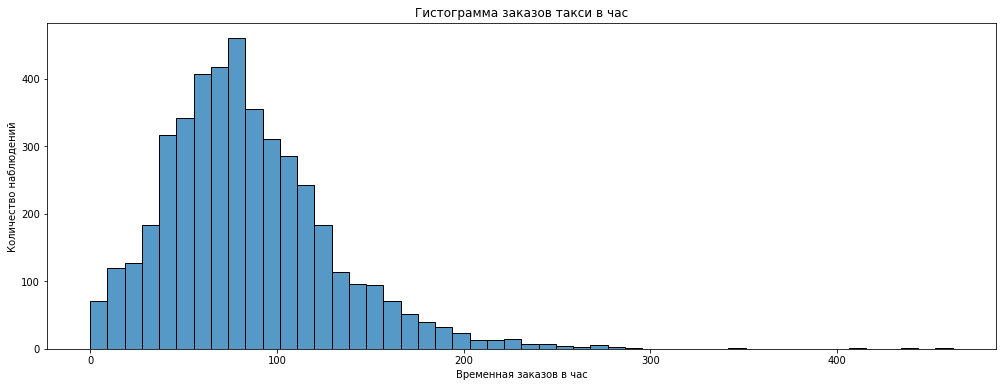

In [7]:
plt.figure(figsize=(17,6))
sb.histplot(data=taxi_resampled['num_orders'], bins=50)
plt.title('Гистограмма заказов такси в час')
plt.xlabel('Временная заказов в час')
plt.ylabel('Количество наблюдений');

Построим график количества заказов в час.

Plot of amount of orders in one hour.

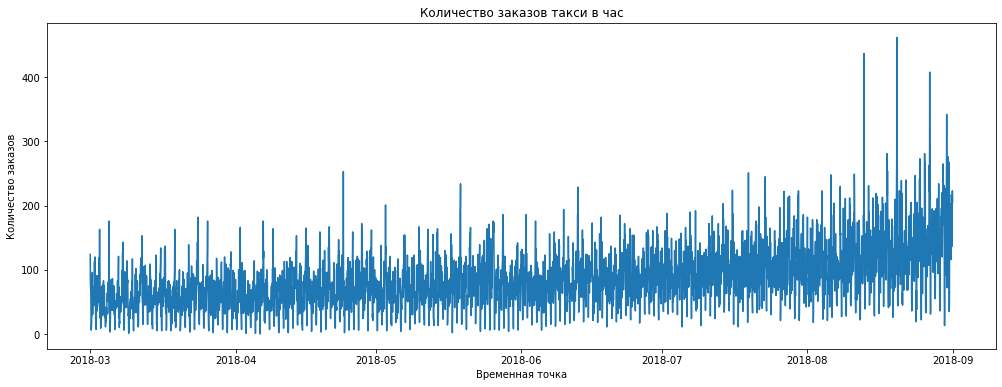

In [8]:
plt.figure(figsize=(17,6))
sb.lineplot(data=taxi_resampled['num_orders'])
plt.title('Количество заказов такси в час')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов');

Снизим колебания путем подсчета скользящего среднего с размером окна 168 (1 неделя). Также посчитаем скользящее стандартное отклонение (с таким же размером окна). Такой размер окна взяли, чтобы лучше сгладить колебания графика и найти тренд.

----

Reduce fluctuations by calculating a moving average with a window size of 168 (1 week). We also calculate the moving standard deviation (with the same window size). This window size was taken in order to better smooth out the chart fluctuations and find a trend.

In [9]:
taxi_resampled['rolling_mean'] = taxi_resampled['num_orders'].rolling(168).mean()
taxi_resampled['rolling_std'] = taxi_resampled['num_orders'].rolling(168).std()

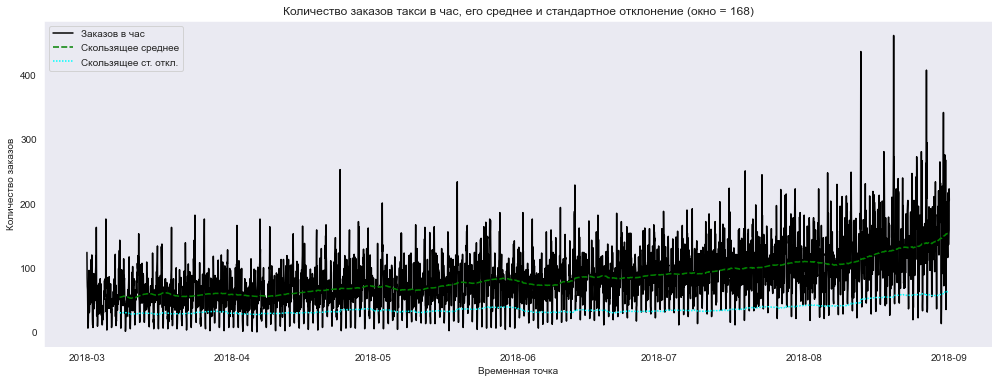

In [10]:
plt.figure(figsize=(17,6))
sb.set_style("dark")
sb.lineplot(data=taxi_resampled, palette=['black', 'green', 'cyan'])
plt.title('Количество заказов такси в час, его среднее и стандартное отклонение (окно = 168)')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов')
plt.legend(['Заказов в час', 'Скользящее среднее', 'Скользящее ст. откл.']);

Видим тренд - рост количества заказов такси со временем. Среднее и стандартное отклонение растет со временем также. Это все говорит о том, что наш временной ряд нестационарный.

Выявить сезонность нельзя, так как у нас данные одного года. Разлодим временной ряд на компоненты: тренд, сезонность, и остатки.

----

We see a trend which is an increase in the number of taxi orders over time. The mean and standard deviation also increases with time. All this suggests that our time series is non-stationary.

It is impossible to identify seasonality, since we have data for one year. Let's decompose the time series into components: trend, seasonality, and residuals.

In [11]:
taxi_decomposed = seasonal_decompose(taxi_resampled['num_orders'])

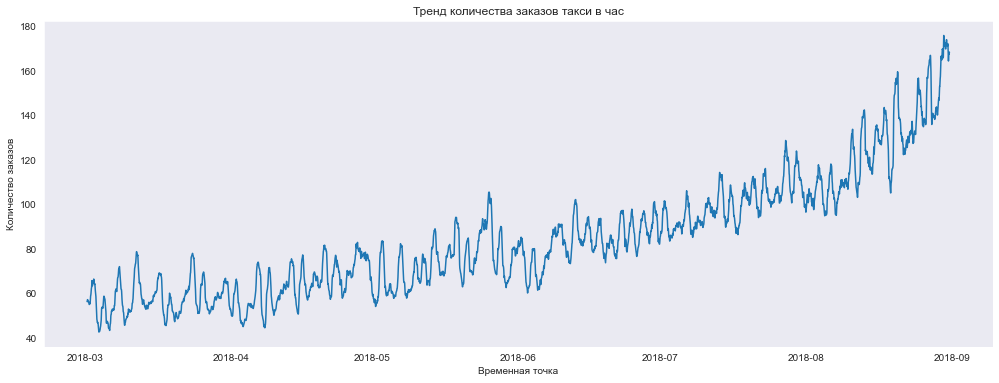

In [12]:
# тренд
plt.figure(figsize=(17,6))
sb.lineplot(data=taxi_decomposed.trend)
plt.title('Тренд количества заказов такси в час')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов');

Видим рост количества заказов такси в час за полгода. Несмотря, на то, что наш ряд **нестационарный**, тренд увеличения количества заказов **линейный**. А значит его можно легко прошнозировать.

-----

We see an increase in the number of taxi orders per hour in six months. Despite the fact that our series is **non-stationary**, the trend of increasing the number of orders is **linear**. This means that it can be easily predicted.

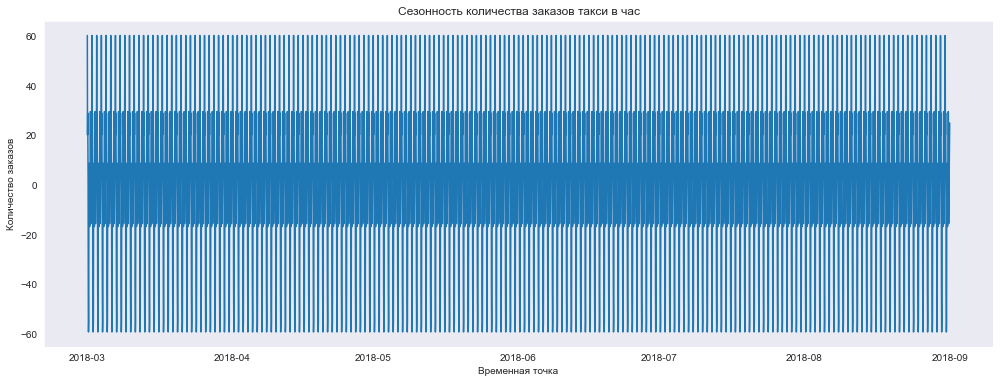

In [13]:
# сезонность
plt.figure(figsize=(17,6))
sb.lineplot(data=taxi_decomposed.seasonal)
plt.title('Сезонность количества заказов такси в час')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов');

Как и говорили ранее, сезонность не можем определить из данных за полгода.

As mentioned earlier, seasonality cannot be determined from the data for six months.

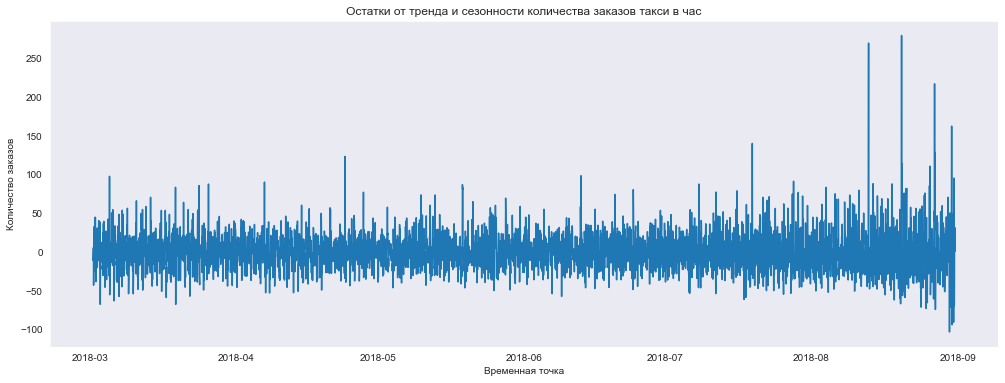

In [14]:
# остатки (шум)
plt.figure(figsize=(17,6))
sb.lineplot(data=taxi_decomposed.resid)
plt.title('Остатки от тренда и сезонности количества заказов такси в час')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов');

Найдем разность временного ряда.

Find differences in time series.

In [15]:
taxi_resampled['diff'] = taxi_resampled['num_orders'] - taxi_resampled['num_orders'].shift()
taxi_resampled['diff_roll_mean'] = taxi_resampled['diff'].rolling(168).mean()
taxi_resampled['diff_roll_std'] = taxi_resampled['diff'].rolling(168).std()
taxi_resampled

,num_orders,rolling_mean,rolling_std,diff,diff_roll_mean,diff_roll_std
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,-39.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,-14.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,-5.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,-23.0,NaN,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,154.434524,62.915078,-71.0,0.136905,65.703282
2018-08-31 20:00:00,154,154.285714,62.886186,18.0,-0.148810,65.519265
2018-08-31 21:00:00,159,154.244048,62.880697,5.0,-0.041667,65.512841


Изобразим все на графике, чтобы увидеть полную картину происходящего.

Plot everything to see a big picture.

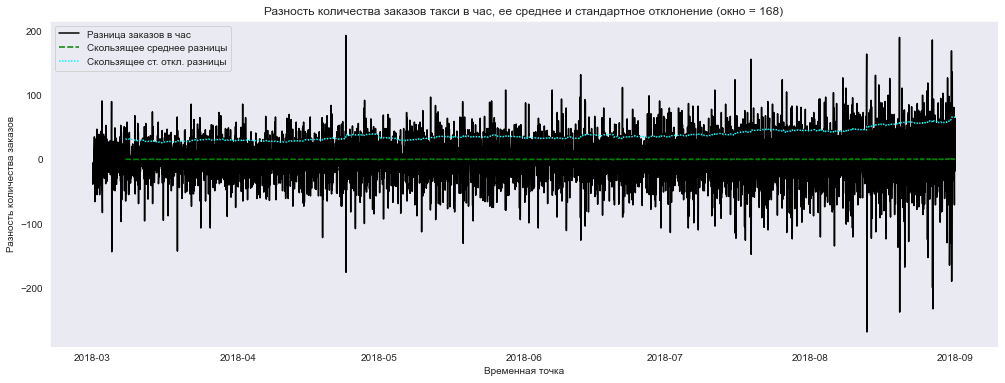

In [16]:
plt.figure(figsize=(17,6))
sb.lineplot(data=taxi_resampled[['diff', 'diff_roll_mean', 'diff_roll_std']], palette=['black', 'green', 'cyan'])
plt.title('Разность количества заказов такси в час, ее среднее и стандартное отклонение (окно = 168)')
plt.xlabel('Временная точка')
plt.ylabel('Разность количества заказов')
plt.legend(['Разница заказов в час', 'Скользящее среднее разницы', 'Скользящее ст. откл. разницы']);

Из графика видно, что разность ряда стационарна. Среднее и стандартное отклонения не изменяются существенно. Для прогнозирования будем использовать разность ряда.

----

It can be seen from the graph that the difference of the series is stationary. The mean and standard deviation do not change significantly. For forecasting, we will use the difference of the series.

## Обучение моделей / Model training

Необходимо обучить модель, которая будет давать RMSE не больше 48 на тестовых данных.

It is required to train a model that will give RMSE no more than 48 on test data.

### Создание признаков / Feature engineering

Создадим функцию, которая будет добавлять необходимые признаки в данные.

Let's create a function that will add the necessary features to the data.

In [18]:
def time_series_features(data, max_lag, rolling_mean_window):
    
    data = data.resample('1H').sum() # ресемпл по одному часу
    
    data = data - data.shift() # таргетом становится разница ряда
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_window).mean()
    
    data = data.dropna(axis=0)
    
    return data

In [20]:
# создадим датафрэйм с признаками, используем разницу ряда как таргет
taxi_ml = time_series_features(taxi, 1, 24)

print(taxi_ml.shape)
taxi_ml.head()

(4391, 5)


,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-02 01:00:00,30.0,4,1,32.0,-1.416667
2018-03-02 02:00:00,-45.0,4,2,30.0,1.458333
2018-03-02 03:00:00,-11.0,4,3,-45.0,0.166667
2018-03-02 04:00:00,-44.0,4,4,-11.0,-0.083333
2018-03-02 05:00:00,-9.0,4,5,-44.0,-0.958333


Использовали гиперпараметры **max_lag**=1 и **rolling_mean_window**=24.

The hyperparameters **max_lag**=1 and **rolling_mean_window**=24 were used.

### Получение обучающей, валидационной и тестовой выборок / Data split to training, validation, and test sets

Разделим данные на 3 выборки в соотношении 70:20:10.

Let's divide the data into 3 samples in the ratio 70:20:10.

In [21]:
features = taxi_ml.drop('num_orders', axis=1)
target = taxi_ml['num_orders']

print(features.shape)
print(target.shape)

(4391, 4)
(4391,)


Создадим выборки.

Create sets.

In [22]:
# обучающая и оставшаяся выборки
train_features, rem_features, train_target, rem_target = train_test_split(features, target, shuffle=False, test_size=0.3,
random_state=1)

print(train_features.shape, '|', train_features.index[0], '|', train_features.index[-1])
print(train_target.shape, '|', train_target.index[0], '|', train_target.index[-1])
print(rem_features.shape, '|', rem_features.index[0], '|', rem_features.index[-1])
print(rem_target.shape, '|', rem_target.index[0], '|', rem_target.index[-1])

(3073, 4) | 2018-03-02 01:00:00 | 2018-07-08 01:00:00
(3073,) | 2018-03-02 01:00:00 | 2018-07-08 01:00:00
(1318, 4) | 2018-07-08 02:00:00 | 2018-08-31 23:00:00
(1318,) | 2018-07-08 02:00:00 | 2018-08-31 23:00:00


In [23]:
# валидационная и тестовая выборки
valid_features, test_features, valid_target, test_target = train_test_split(rem_features, rem_target, shuffle=False, test_size=0.33,
random_state=1)

print(valid_features.shape, '|', valid_features.index[0], '|', valid_features.index[-1])
print(valid_target.shape, '|', valid_target.index[0], '|', valid_target.index[-1])
print(test_features.shape, '|', test_features.index[0], '|', test_features.index[-1])
print(test_target.shape, '|', test_target.index[0], '|', test_target.index[-1])

(883, 4) | 2018-07-08 02:00:00 | 2018-08-13 20:00:00
(883,) | 2018-07-08 02:00:00 | 2018-08-13 20:00:00
(435, 4) | 2018-08-13 21:00:00 | 2018-08-31 23:00:00
(435,) | 2018-08-13 21:00:00 | 2018-08-31 23:00:00


Вывели на экран индексы созданных выборок, чтобы убедиться, что они идут в хронологическом порядке. Нельзя обучать модель на данных из будущего. Разделение провели верно, данные идут в хронологическом порядке.

----

Displayed the indexes of the generated selections to make sure they are in chronological order. You cannot train a model on data from the future. The division was carried out correctly, the data is in chronological order.

### Создание и проверка базовых моделей / Base models

Создадим модели, которые прогнозируют целевую переменную постоянным значением (например, средним) или прогнозирует переменную предыдущим значением. Эти модели помогут нам оценить адекватность наших будущих серьезных моделей.

----

Let's create models that predict the target variable by a constant value (for example, the mean) or predict the variable by the previous value. These models will help us evaluate the adequacy of our future serious models.

#### Прогноз заказов такси средним / Prediction by mean

In [24]:
# создадим модель предсказывающую среднее занчение тренировочной выборки
model_mean = DummyRegressor(strategy='mean')
model_mean.fit(train_features, train_target)

DummyRegressor()

In [25]:
# сделаем предсказания
predictions_train_mean = model_mean.predict(train_features)
predictions_valid_mean = model_mean.predict(valid_features)

print(predictions_train_mean.shape)
print(predictions_valid_mean.shape)

(3073,)
(883,)


In [26]:
# подсчитаем качество предсказания метрикой RMSE
rmse_mean_train = np.sqrt(mean_squared_error(train_target, predictions_train_mean))
rmse_mean_valid = np.sqrt(mean_squared_error(valid_target, predictions_valid_mean))

print('RMSE модели предсказания средним для ТРЕНИРОВОЧНЫХ данных:', round(rmse_mean_train, 2))
print('RMSE модели предсказания средним для ВАЛИДАЦИОННЫХ данных:', round(rmse_mean_valid, 2))

RMSE модели предсказания средним для ТРЕНИРОВОЧНЫХ данных: 33.2
RMSE модели предсказания средним для ВАЛИДАЦИОННЫХ данных: 45.06


RMSE тренировочных данных ниже, чем на валидационных. Это логично так как модель обучалась на тренировочных данных и может предсказать их лучше, а валидационные данные модель никогда не видела. Также значение метрики на валидационных данных не превышает заданный порог. Посмотрим на метрики после прогнозирования предыдущим значением.

----

The RMSE of the training data is lower than that of the validation data. This is logical since the model was trained on the training data and can predict them better, but the model has never seen the validation data. Also, the value of the metric on the validation data does not exceed the specified threshold. Let's look at the metrics after predicting the previous value.

#### Прогноз заказов такси предыдущим значением / Prediction of taxi orders by previous value

In [27]:
# сделаем предсказания предыдущим элементом
predictions_previous_train = train_target.shift()
predictions_previous_train.iloc[0] = 0
print(predictions_previous_train.head())
print()

predictions_previous_valid = valid_target.shift()
predictions_previous_valid.iloc[0] = train_target.loc[train_target.index.max()]
predictions_previous_valid.head()

datetime
2018-03-02 01:00:00     0.0
2018-03-02 02:00:00    30.0
2018-03-02 03:00:00   -45.0
2018-03-02 04:00:00   -11.0
2018-03-02 05:00:00   -44.0
Freq: H, Name: num_orders, dtype: float64



datetime
2018-07-08 02:00:00     -5.0
2018-07-08 03:00:00     15.0
2018-07-08 04:00:00     83.0
2018-07-08 05:00:00   -110.0
2018-07-08 06:00:00     -9.0
Freq: H, Name: num_orders, dtype: float64

In [28]:
# посчитаем RMSE
rmse_prev_train = np.sqrt(mean_squared_error(train_target, predictions_previous_train))
rmse_prev_valid = np.sqrt(mean_squared_error(valid_target, predictions_previous_valid))

print('RMSE модели предсказания предыдущим значением для ТРЕНИРОВОЧНЫХ данных:', round(rmse_prev_train, 2))
print('RMSE модели предсказания предыдущим значением для ВАЛИДАЦИОННЫХ данных:', round(rmse_prev_valid, 2))

RMSE модели предсказания предыдущим значением для ТРЕНИРОВОЧНЫХ данных: 53.53
RMSE модели предсказания предыдущим значением для ВАЛИДАЦИОННЫХ данных: 72.84


Предсказание значений предыдущим из ряда работает хуже. Метрика RMSE выросла и превышает пороговое значение (даже на тренировочных данных).

----

Predicting the values of the previous row works worse. The RMSE metric has risen and is above the threshold (even on training data).

Сейчас мы работали с данными, которые были получены с помощью функции **time_series_features()**. Главные гиперпараметры этой функции - ***max_lag*** и ***rolling_mean_window***. Они напрямую влияют на количество и качество признаков, которые будут в наших выборках. Найдем такие гиперпараметры, которые будут давать наименьшую метрику RMSE.

----

We have now worked with data that was obtained using the **time_series_features()** function. The main hyperparameters of this function are ***max_lag*** and ***rolling_mean_window***. They directly affect the quantity and quality of features that will be in our samples. Let's find such hyperparameters that will give the smallest RMSE metric.

#### Подбор гиперпараметров для предсказания средним и предыдущим значением / Optimization of hyperparameters for prediction by mean and previous value.

##### Предсказание средним / Prediction by mean

In [29]:
# создадим занчения гиперпараметров для проверки
max_lag_values = np.arange(1, 51)
rolling_mean_window_values = np.arange(1, 51)

# создадим пустые Series, куда будем записывать RMSE
train_rmses = pd.Series([]) 
valid_rmses = pd.Series([])

# пройдемся вложенным циклом по гиперпараметрам
# будем передавать их в функцию time_series_features()
# разделять на тренировочный и валидационный датасеты
# делать предсказание средним и проверять RMSE
for lag in max_lag_values:
    for window in rolling_mean_window_values:
        
        data = time_series_features(taxi, lag, window) # создаем данные с признаками
        
        f = data.drop('num_orders', axis=1) # делим на признаки и таргет
        t = data['num_orders']
        
        # обучающая и оставшаяся выборки
        train_features_mean, rem_features_mean, train_target_mean, rem_target_mean = train_test_split(f, t, shuffle=False, test_size=0.3,
        random_state=1)
        
        # валидационная и тестовая выборки
        valid_features_mean, test_features_mean, valid_target_mean, test_target_mean = train_test_split(rem_features_mean, rem_target_mean, shuffle=False, test_size=0.33,
        random_state=1) # создаем здесь тестовую выборку (10%), но не испольуем ее, чтобы скрыть от модели тестовые данные, которые будем проверять в будущем

        model_mean.fit(train_features_mean, train_target_mean)
        pred_train = model_mean.predict(train_features_mean)
        pred_valid = model_mean.predict(valid_features_mean)
        
        train_rmse = pd.Series(np.sqrt(mean_squared_error(train_target_mean, pred_train)), index=[str(lag)+'_'+str(window)])
        valid_rmse = pd.Series(np.sqrt(mean_squared_error(valid_target_mean, pred_valid)), index=[str(lag)+'_'+str(window)])
        
        train_rmses = pd.concat([train_rmses, train_rmse])
        valid_rmses = pd.concat([valid_rmses, valid_rmse])

C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\1910179151.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_rmses = pd.Series([])
C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\1910179151.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  valid_rmses = pd.Series([])


Построим графики зависимости RMSE от гиперпараметров функции **time_series_features(max_lag, rolling_mean_window)** при проверке модели на тренировочных и валидационных данных. Значения гиперапарметров отмечены на оси x в следующем формате: **(max_lag)**_**(rolling_mean_window)**.

-----

Let's build plots of RMSE dependence on the hyperparameters of the function **time_series_features(max_lag, rolling_mean_window)** when checking the model on training and validation data. Hyperparameter values are marked on the x-axis in the following format: **(max_lag)**_**(rolling_mean_window)**.

Минмальное значение RMSE на тренировочных данных: 33.19 | Гиперпараметры: 1_12
Минмальное значение RMSE на валидационных данных: 44.95 | Гиперпараметры: 1_33


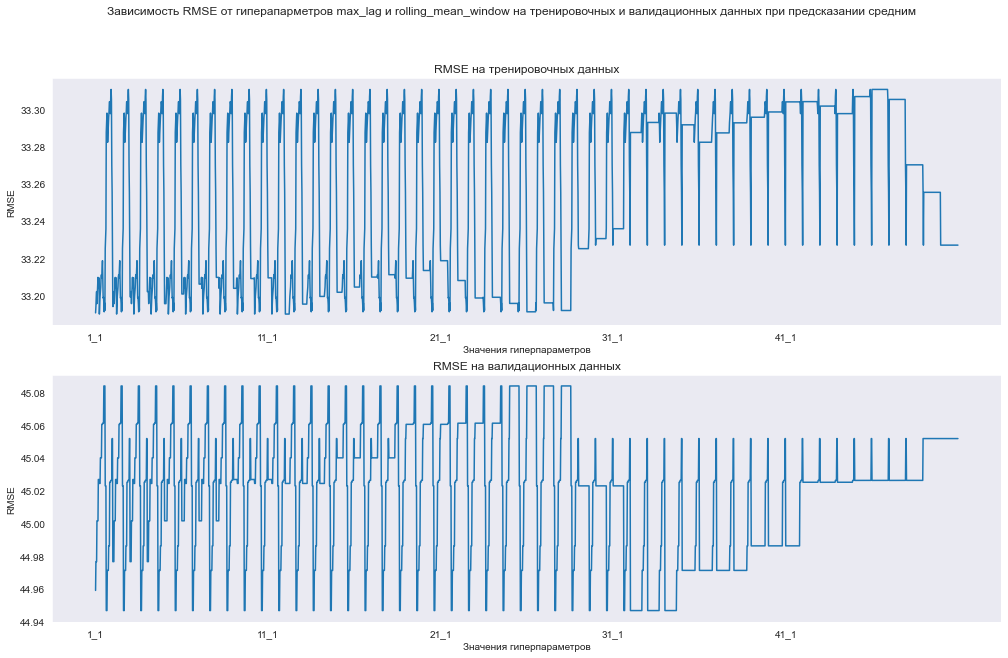

In [30]:
fig, axes = plt.subplots(2,1, figsize=(17,10))

fig.suptitle('Зависимость RMSE от гиперапарметров max_lag и rolling_mean_window на тренировочных и валидационных данных при предсказании средним')

train_rmses.plot(ax=axes[0])
axes[0].set_title('RMSE на тренировочных данных')
axes[0].set_xlabel('Значения гиперпараметров')
axes[0].set_ylabel('RMSE')

valid_rmses.plot(ax=axes[1])
axes[1].set_title('RMSE на валидационных данных')
axes[1].set_xlabel('Значения гиперпараметров')
axes[1].set_ylabel('RMSE');

print('Минмальное значение RMSE на тренировочных данных:', round(train_rmses.min(), 2), '|', 'Гиперпараметры:', train_rmses.idxmin())
print('Минмальное значение RMSE на валидационных данных:', round(valid_rmses.min(), 2), '|', 'Гиперпараметры:', valid_rmses.idxmin())

RMSE ниже порога на тренировочных данныхи выше порога на валидационных данных. Обучение для предсказания средним стоить делать на тренирововчных данных, полученных  с гиперпараметрами max_lag=1 и rolling_mean_window=33. Теперь попробуем подобрать параметры для модели предсказания предыдущим значением.

---

RMSE below threshold on training data and above threshold on validation data. Training for mean prediction should be done on training data obtained with hyperparameters max_lag=1 and rolling_mean_window=33. Now let's try to choose the parameters for the prediction model by the previous value.

##### Предсказание предыдущим значением / Prediction by previous value

In [31]:
# создадим пустые Series, куда будем записывать RMSE
train_rmses = pd.Series([]) 
valid_rmses = pd.Series([])

# пройдемся вложенным циклом по гиперпараметрам
# будем передавать их в функцию time_series_features()
# разделять на тренировочный и валидационный датасеты
# делать предсказание предыдущим значением и проверять RMSE
for lag in max_lag_values:
    for window in rolling_mean_window_values:
        
        data = time_series_features(taxi, lag, window) # создаем данные с признаками
        
        f = data.drop('num_orders', axis=1) # делим на признаки и таргет
        t = data['num_orders']
        
        # обучающая и валидационная выборки
        train_features_prev, rem_features_prev, train_target_prev, rem_target_prev = train_test_split(f, t, shuffle=False, test_size=0.3,
        random_state=1)
        
        # валидационная и тестовая выборки
        valid_features_prev, test_features_prev, valid_target_prev, test_target_prev = train_test_split(rem_features_prev, rem_target_prev, shuffle=False, test_size=0.33,
        random_state=1) # создаем здесь тестовую выборку (10%), но не испольуем ее, чтобы скрыть от модели тестовые данные, которые будем проверять в будущем

        predictions_previous_train = train_target_prev.shift()
        predictions_previous_train.iloc[0] = 0

        predictions_previous_valid = valid_target_prev.shift()
        predictions_previous_valid.iloc[0] = train_target.loc[train_target.index.max()]
        
        train_rmse = pd.Series(np.sqrt(mean_squared_error(train_target_prev, predictions_previous_train)), index=[str(lag)+'_'+str(window)])
        valid_rmse = pd.Series(np.sqrt(mean_squared_error(valid_target_prev, predictions_previous_valid)), index=[str(lag)+'_'+str(window)])
        
        train_rmses = pd.concat([train_rmses, train_rmse])
        valid_rmses = pd.concat([valid_rmses, valid_rmse])

C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\365867652.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_rmses = pd.Series([])
C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\365867652.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  valid_rmses = pd.Series([])


Минмальное значение RMSE на тренировочных данных: 53.52 | Гиперпараметры: 1_26
Минмальное значение RMSE на валидационных данных: 72.57 | Гиперпараметры: 1_32


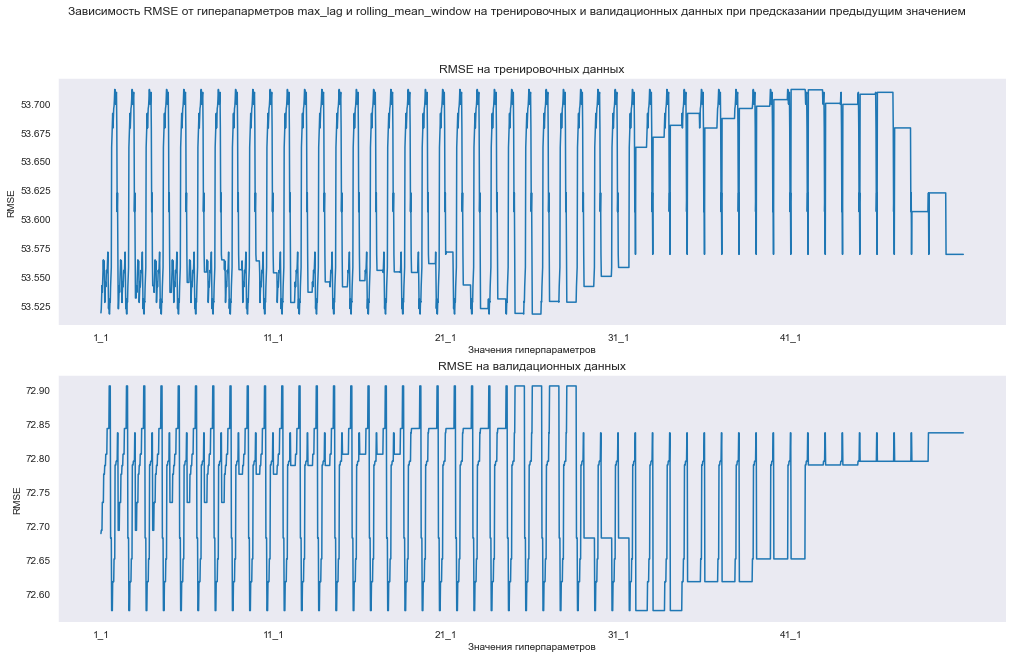

In [32]:
fig, axes = plt.subplots(2,1, figsize=(17,10))

fig.suptitle('Зависимость RMSE от гиперапарметров max_lag и rolling_mean_window на тренировочных и валидационных данных при предсказании предыдущим значением')

train_rmses.plot(ax=axes[0])
axes[0].set_title('RMSE на тренировочных данных')
axes[0].set_xlabel('Значения гиперпараметров')
axes[0].set_ylabel('RMSE')

valid_rmses.plot(ax=axes[1])
axes[1].set_title('RMSE на валидационных данных')
axes[1].set_xlabel('Значения гиперпараметров')
axes[1].set_ylabel('RMSE');

print('Минмальное значение RMSE на тренировочных данных:', round(train_rmses.min(), 2), '|', 'Гиперпараметры:', train_rmses.idxmin())
print('Минмальное значение RMSE на валидационных данных:', round(valid_rmses.min(), 2), '|', 'Гиперпараметры:', valid_rmses.idxmin())

Предсказание предыдущим значением, как и ожидалось, работает хуже. Гиперпараметры для лучшей модели (определены на валидационной выборке): max_lag = 1, rolling_mean_window = 32. Минимальное RMSE: 72.57. Значение RMSE для этих гиперпараметров отличается от того, которое мы получили ранее, так как размер обучающей и валидационной выборок отличаются.

----

Prediction by the previous value, as expected, performs worse. Hyperparameters for the best model (determined on the validation set): max_lag = 1, rolling_mean_window = 32. Minimum RMSE: 72.57. The RMSE value for these hyperparameters is different from the one we obtained earlier, since the size of the training and validation samples is different.

Мы поняли как работают базовые модели и теперь можем построить основные, и сравнить их с базовыми.

We have checked how the base models work and now we can build the main ones and compare them with the base ones.

### Создание и проверка основных моделей / Training and assesment of main models

Наша задача - спрогнозировать количество заказов такси в следующий час (это наш шаг). Количество такси - случайная дискретная величина. Следовательно, перед нами задача **регресии**. Можно попробовать обыкновенную линейную регрессию.

----

Our task is to predict the number of taxi orders in the next hour (this is our step). The number of taxis is a random discrete value. Therefore, we face the task of **regression**. You can try a simple linear regression.

#### Линейная регрессия (max_lag=1, rolling_mean=24) / Linear regression (max_lag=1, rolling_mean=24)

In [34]:
model_lr = LinearRegression()

model_lr.fit(train_features, train_target)

lr_train_predictions = model_lr.predict(train_features)
lr_valid_predictions = model_lr.predict(valid_features)

rmse_lr_train = np.sqrt(mean_squared_error(train_target, lr_train_predictions))
rmse_lr_valid = np.sqrt(mean_squared_error(valid_target, lr_valid_predictions))

print('RMSE линейной регрессии для ТРЕНИРОВОЧНЫХ данных:', round(rmse_lr_train, 2))
print('RMSE линейной регрессии для ВАЛИДАЦИОННЫХ данных:', round(rmse_lr_valid, 2))

RMSE линейной регрессии для ТРЕНИРОВОЧНЫХ данных: 30.48
RMSE линейной регрессии для ВАЛИДАЦИОННЫХ данных: 40.79


Линейная регрессия предсказывает на валидационных данных лучше, чем просто предсказание средним. RMSE ниже 48. Попробуем оптимизировать гиперпараметры функции time_series_features().

----

Linear regression predicts better on the validation data than just predicting by means. RMSE is below 48. Let's try to optimize the hyperparameters of the time_series_features() function.

#### Оптимизация линейной регрессии / Linear regression optimization

In [35]:
# создадим занчения гиперпараметров для проверки
max_lag_values = np.arange(1, 101)
rolling_mean_window_values = np.arange(1, 101)

# создадим пустые Series, куда будем записывать RMSE
train_rmses = pd.Series([]) 
valid_rmses = pd.Series([])

# пройдемся вложенным циклом по гиперпараметрам
# будем передавать их в функцию time_series_features()
# разделять на тренировочный и валидационный датасеты
# делать предсказание линейной регрессией и проверять RMSE
for lag in max_lag_values:
    for window in rolling_mean_window_values:
        
        data = time_series_features(taxi, lag, window) # создаем данные с признаками
        
        f = data.drop('num_orders', axis=1) # делим на признаки и таргет
        t = data['num_orders']
        
        # обучающая и валидационная выборки
        train_features_lr, rem_features_lr, train_target_lr, rem_target_lr = train_test_split(f, t, shuffle=False, test_size=0.3,
        random_state=1)

        # валидационная и тестовая выборки
        valid_features_lr, test_features_lr, valid_target_lr, test_target_lr = train_test_split(rem_features_lr, rem_target_lr, shuffle=False, test_size=0.33,
        random_state=1) # создаем здесь тестовую выборку (10%), но не испольуем ее, чтобы скрыть от модели тестовые данные, которые будем проверять в будущем

        model_lr.fit(train_features_lr, train_target_lr)

        lr_train_predictions = model_lr.predict(train_features_lr)
        lr_valid_predictions = model_lr.predict(valid_features_lr)
        
        train_rmse = pd.Series(np.sqrt(mean_squared_error(train_target_lr, lr_train_predictions)), index=[str(lag)+'_'+str(window)])
        valid_rmse = pd.Series(np.sqrt(mean_squared_error(valid_target_lr, lr_valid_predictions)), index=[str(lag)+'_'+str(window)])
        
        train_rmses = pd.concat([train_rmses, train_rmse])
        valid_rmses = pd.concat([valid_rmses, valid_rmse])

C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\3479767985.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_rmses = pd.Series([])
C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\3479767985.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  valid_rmses = pd.Series([])
C:\Users\vododokhov\AppData\Local\Temp\ipykernel_6656\3241404100.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_window).mean()
C:\Users\vododokhov\AppData\Local\Temp\

Минмальное значение RMSE на тренировочных данных: 20.24 | Гиперпараметры: 99_1
Минмальное значение RMSE на валидационных данных: 28.93 | Гиперпараметры: 72_95


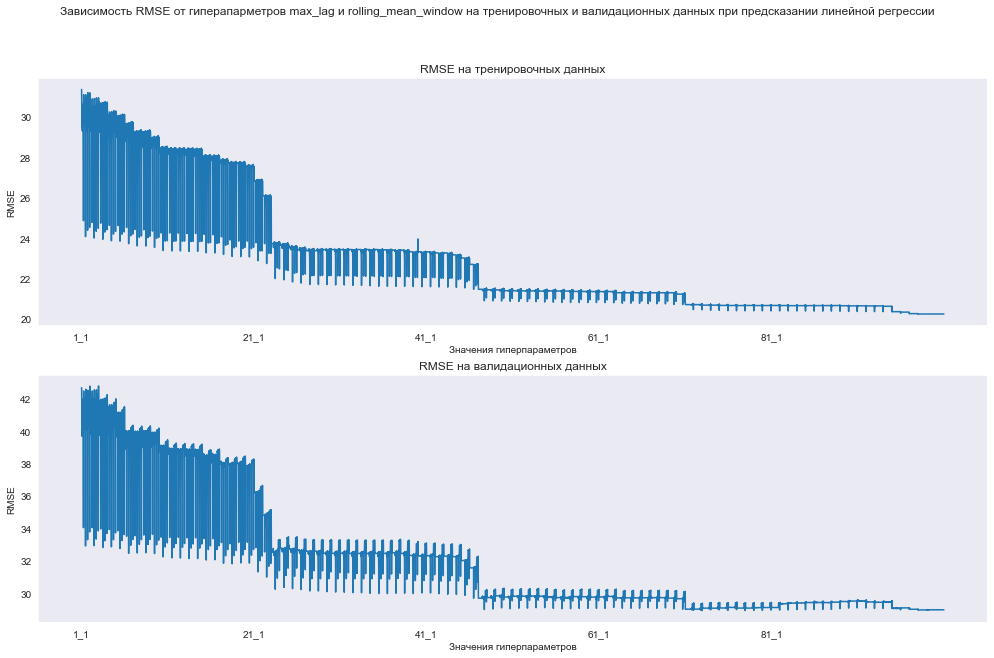

In [36]:
fig, axes = plt.subplots(2,1, figsize=(17,10))

fig.suptitle('Зависимость RMSE от гиперапарметров max_lag и rolling_mean_window на тренировочных и валидационных данных при предсказании линейной регрессии')

train_rmses.plot(ax=axes[0])
axes[0].set_title('RMSE на тренировочных данных')
axes[0].set_xlabel('Значения гиперпараметров')
axes[0].set_ylabel('RMSE')

valid_rmses.plot(ax=axes[1])
axes[1].set_title('RMSE на валидационных данных')
axes[1].set_xlabel('Значения гиперпараметров')
axes[1].set_ylabel('RMSE');

print('Минмальное значение RMSE на тренировочных данных:', round(train_rmses.min(), 2), '|', 'Гиперпараметры:', train_rmses.idxmin())
print('Минмальное значение RMSE на валидационных данных:', round(valid_rmses.min(), 2), '|', 'Гиперпараметры:', valid_rmses.idxmin())

Линейная регрессия хорошо предсказывает на валидационных данных. Оптимизированные гиперпараметры для линейной регрессии: max_lag=72, rolling_mean_window=95.

----

Linear regression predicts well on validation data. Optimized hyperparameters for linear regression: max_lag=72, rolling_mean_window=95.

#### ARIMA

Попробуем модели, предназначенные для предсказания временных рядов. Одной из них является **ARIMA (Auto Regressive Integrated Moving Average)**. Эта модель имеет 3 параметра: p, d, q.

 p: Число отстающих значений (lag) - Auto-Regressive terms.

• q: Окно скользящего среднего - Moving-Average terms.

• d: Число разниц.

Определить их можно построив автокорреляционный график или частично автокорреляционный график.

----

Let's try models designed to predict time series. One of them is **ARIMA (Auto Regressive Integrated Moving Average)**. This model has 3 parameters: p, d, q.

  p: Number of lagging values (lag) - Auto-Regressive terms.

• q: Moving-Average terms window.

• d: Number of differences.

We can determine them by building an autocorrelation plot or a partially autocorrelation plot.

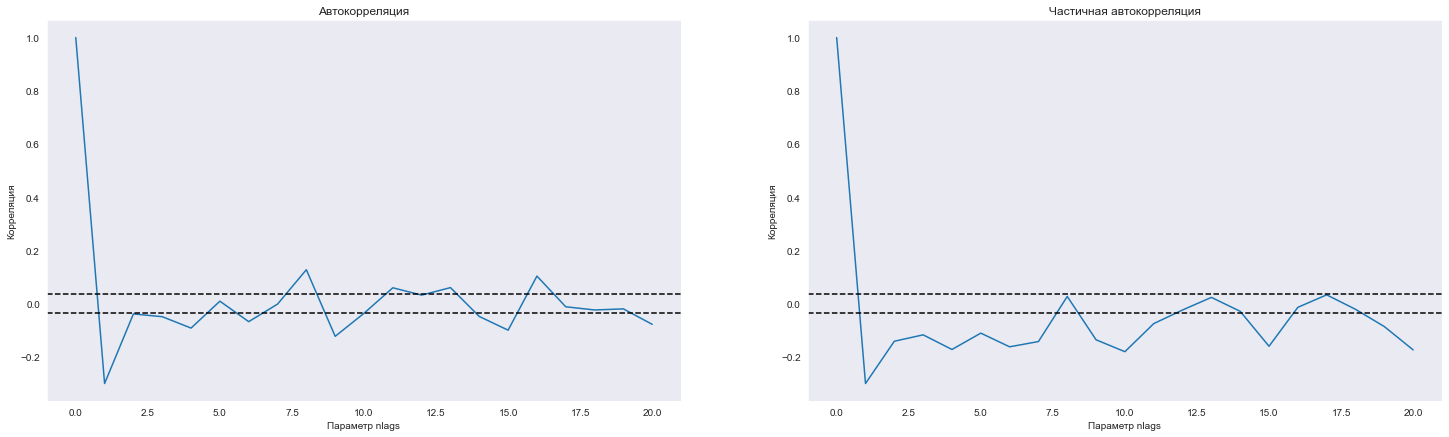

In [37]:
# посчитаем автокорреляцию и частичную автокорреляцию
lag_acf = acf(train_target, nlags=20, alpha=.05)
lag_pacf = pacf(train_target, nlags=20, method='ols', alpha=0.05)

#отобразим на графике
fig, axes = plt.subplots(1, 2, figsize=(25,7))

# acf
sb.lineplot(data=lag_acf[0], ax=axes[0])
axes[0].axhline(y=-1.96/np.sqrt(len(train_target)),linestyle='--', color='black')
axes[0].axhline(y=1.96/np.sqrt(len(train_target)), linestyle='--', color='black')
axes[0].set_title('Автокорреляция')
axes[0].set_xlabel('Параметр nlags')
axes[0].set_ylabel('Корреляция')

# pacf
sb.lineplot(data=lag_pacf[0], ax=axes[1])
axes[1].axhline(y=-1.96/np.sqrt(len(train_target)), linestyle='--', color='black')
axes[1].axhline(y=1.96/np.sqrt(len(train_target)),linestyle='--', color='black')
axes[1].set_title('Частичная автокорреляция')
axes[1].set_xlabel('Параметр nlags')
axes[1].set_ylabel('Корреляция');

Параметры p и q определяются в месте пересечения графика с верхней границей доверительного интервала.

p: График **частичной автокорреляции** пересекает верхнюю границу доверительного интервала при nlags=~1.5. Округлим до 2.

q: График **автокорреляции** пересекает верхнюю границу доверительного интервала при nlags=~1.5. Также округлим до 2.

Параметры для модели выбраны. Посмотрим как она предсказывает количество заказов такси.

----

The parameters p and q are determined at the intersection of the graph with the upper limit of the confidence interval.

p: The **partial autocorrelation** plot crosses the upper bound of the confidence interval at nlags=~1.5. Round up to 2.

q: The **autocorrelation** plot crosses the upper limit of the confidence interval at nlags=~1.5. Also round up to 2.

The parameters for the model are selected. Let's see how it predicts the number of taxi orders.

In [38]:
model_arima = ARIMA(train_target, order=(2,1,2)) # order - p, d, q
results_model_arima = model_arima.fit()

arima_pred = results_model_arima.get_forecast(len(valid_target.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = results_model_arima.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = valid_target.index
arima_pred_out = arima_pred_df["Predictions"]

rmse_valid_arima = np.sqrt(mean_squared_error(valid_target, arima_pred_out))
print('RMSE модели ARIMA на валидационной выборке:', round(rmse_valid_arima, 2))

RMSE модели ARIMA на валидационной выборке: 44.85


ARIMA работает хуже обыкновенной линейной регрессии, но значение RMSE ниже порогового. Теперь проверим модель линейной регрессии на тестовой выборке, чтобы убедиться в ее точности.

----

ARIMA performs worse than ordinary linear regression, but the RMSE value is below the threshold. Now let's test the linear regression model on the test set to make sure it's accurate.

## Проверка моделей на тестовой выборке / Model assesment on test data

Самая лучшая метрика RMSE была у оптимизированной линейной регрессии (RMSE=28.93). Гиперапараметры для создания признаков: max_lag=72, rolling_mean_window=95.

Так как мы создавали все выборки либо с гиперапараметрами, равными 1, или создавали их внутри циклов при оптимизации гиперпараметров, необходимо создать тренирововчную, валидационную, и тестовую выборки еще раз. Валидационная сейчас не будет использоваться, но ее необходимо указать, что у нас в тестовой выборке, не оказалось данных, которые использовались либо при обучении, либо при тестировании модели на валидационной выборке.

----

The best RMSE metric was the optimized linear regression (RMSE=28.93). Hyperparameters for creating features: max_lag=72, rolling_mean_window=95.

Since we created all samples either with hyperparameters equal to 1, or created them inside loops when optimizing hyperparameters, we need to create training, validation, and test samples again. The validation one will not be used now, but it must be indicated that in our test sample, there were no data that were used either when training or when testing the model on the validation sample.

In [40]:
data_72_95 = time_series_features(taxi, 72, 95) # создаем данные с признаками max_lag=72, rolling_mean_window=95
        
f_72_95 = data.drop('num_orders', axis=1) # делим на признаки и таргет
t_72_95 = data['num_orders']
        
# обучающая и оставшаяся выборки
train_features_lr_72_95, rem_features_lr_72_95, train_target_lr_72_95, rem_target_lr_72_95 = train_test_split(f_72_95, t_72_95, shuffle=False, test_size=0.3, random_state=1)

# оставшаяся и тестовая выборки
valid_features_lr_72_95, test_features_lr_72_95, valid_target_lr_72_95, test_target_lr_72_95 = train_test_split(rem_features_lr_72_95, rem_target_lr_72_95, shuffle=False, test_size=0.33, random_state=1)

# обучаем модель
model_lr_72_95 = LinearRegression()
model_lr_72_95.fit(train_features_lr_72_95, train_target_lr_72_95)

# делаем предсказаніе
lr_72_95_test_predictions = model_lr_72_95.predict(test_features_lr_72_95)

test_rmse_72_95 = np.sqrt(mean_squared_error(test_target_lr_72_95, lr_72_95_test_predictions))
        
print('RMSE на ТЕСТОВОЙ выборке для оптимизированной линейной регрессии:', round(test_rmse_72_95, 2))

RMSE на ТЕСТОВОЙ выборке для оптимизированной линейной регрессии: 40.32


Получили метрику RMSE на тестовых данных 40.3. Это соответствует нашим критериям для метрики.

We got the RMSE metric on test data 40.3. This meets our criteria for the metric.

Построим график, где отразим реальные и предсказанные значения, чтобы визуально оценить качество модели оптимизированной линейной регрессии.

---

Let's build a graph that reflects the real and predicted values in order to visually assess the quality of the optimized linear regression model.

In [72]:
# ресеплируем данные для графиков
lr_72_95_test_predictions_for_plot = pd.Series(lr_72_95_test_predictions, index=test_features_lr_72_95.index).resample('2D').sum()
test_target_lr_72_95_for_plot = test_target_lr_72_95.resample('2D').sum()

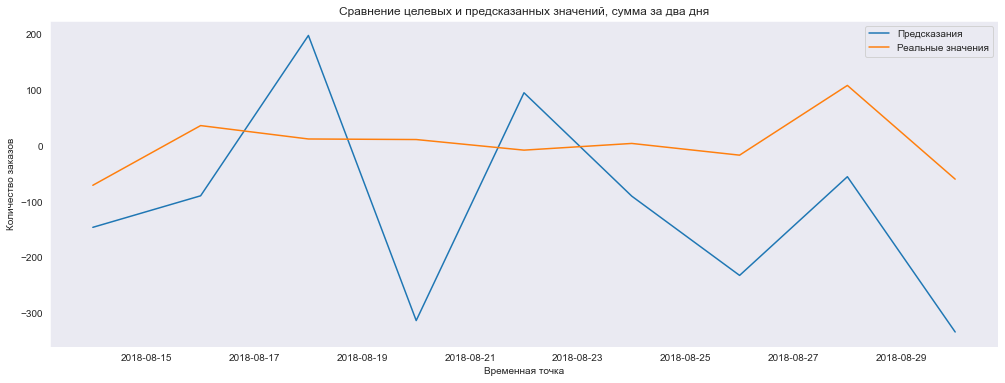

In [83]:
plt.figure(figsize=(17,6))
sb.lineplot(data=lr_72_95_test_predictions_for_plot)
sb.lineplot(data=test_target_lr_72_95_for_plot)
plt.title('Сравнение целевых и предсказанных значений, сумма за два дня')
plt.xlabel('Временная точка')
plt.ylabel('Количество заказов')
plt.legend(labels=['Предсказания', 'Реальные значения']);

Судя по графику, модель слабая. Где-то переоценила значения, где-то недооценила, но в среднем мы видим, что вроде предсказывает хорошо.

---

Judging by the graph, the model is weak. Somewhere I overestimated the values, somewhere I underestimated them, but on average we see that it seems to predict well.

## Общий вывод / Conclusion

В данном проекте мы работали с временными рядами и строили модель предсказания количества заказов такси на следующий час.

Временные ряды - очень специфический тип данных, при работе с которым, необходимо соблюдать определенные принципы.

1) Например, надо убедиться, что данные отсортированны по возрастанию во времени (более старые временные точки идут первыми). Этот порядок должен соблюдаться на протяжении всех шагов (построение модели, ее проверка). Если допустить попадание будущих данных в обучающую выборку, предсказание будет недостоверным.

2) Большинство данных с временными рядами - шумные. Это значит, что кратковременные колебания показаний мешают разглядеть тренды и сезонность. Чтобы сгладить шум, применяют ресемплирование. Например, вычисляют среднее показателя за какой-то промежуток времени (в нашем случае за час).

3) Следует различать понятия **тренд** и **сезонность** при работе с временными рядами. Сезонность можно определить тольео если есть данные за несколько лет. В нашем случае, мы имели данные за полгода. Следовательно, могли определить только тренд. Со временем количество заказов такси повышается.

4) Необходимо определить какой ряд, стационарный или нет. Нестационарный ряд имеет изменяющееся во времени среднее и стандартное отклонение. Такой ряд не подходит для предсказания. Напротив, стационарный ряд может использоваться для прогнозирования. Мы сделали наш ряд стационарным путем нахождения разницы ряда. Это временной ряд, в котором целевыми значениями выступают разницы между значением и предыдущим значением.

5) Так как временный ряд стостоит только из целевого признака, необходимо уметь создавать фичи. В качестве признаков могут служить: отстающие значения (устанавливается параметром max_lag), скользящее среднее (кстанавливается параметром rolling_mean_window), части даты (год, месяц, день).

6) Чтобы оценить адекатность моделей, мы построили dummy модели, где предсказывали количество такси средним по тренировочной выборке, или предыдущим значением в ряде. Сначала мы построили такие модели на тренирововчных данных, которые были созданы с параметрами max_lag=1, rolling_mean_window=24. Модель предсказания средним показала метрику RMSE = **45.06**, а модель предсказания предыдущим значением показала RMSE = **72.84**. Эти модели были построены, чтобы оценить наши основные модели, сравниявая с этими.

7) Далее мы оптимизировали параметры max_lag и rolling_mean_window для моделей предсказания средним и предыдущим значением. Метрика RMSE после оптимизации были очень похожа на метрику до оптимизации (**72.57** для предсказания предыдущим значением, **44.95** для модели предсказания средним). Сделали вывод, что оптимизация параметров не влияет на качество "глупых" моделей. Предсказание предыдущим значением не точное.

6) Построили модель линейной регрессии, чтобы найти закономерности в ряде и спрогнозировать будущее значение точнее. Сначала обучили модель на данных, полученных с параметрами max_lag=1, rolling_mean_window=24. Получили метрику RMSE на валидационных данных, равную **40.79**.

7) Далее подобрали параметры max_lag и rolling_mean_window, чтобы получить минимальную RMSE линейной регрессии на валидационных данных. При max_lag=72 и rolling_mean_window=95 RMSE на валидационной выборке составила **28.93**. Улучшение составило 32.5% по сравнению с сырой моделью линейной регрессии.

8) Также применили специальную модель, созданную для прогнозирования временных рядов - ARIMA. С помощью графиков подобрали параметры этой модели. Обучили её и получили метрику RMSE на валидационной выборке, равную **44.85**. Похуже, чем линейная регрессия.

9) В качестве модели для проверки на тестовых данных выбрали оптимизированнуб линейную регрессию. Метрика RMSE составила **40.3**, что ниже ранее установленного порога 48. Однако, график сравнения целевых и предсказанных значений показал, что модель плохо прогнозирует значения.

10) Линейная регрессия и параметры max_lag=72 и rolling_mean_window=95 были выбраны в качестве финального решения для этих данных.

----

In this project, we worked with time series and built a model for predicting the number of taxi orders for the next hour.

Time series is a very specific type of data, and when working with it, certain principles must be observed.

1) For example, you need to make sure that the data is sorted in ascending time order (older time points come first). This order must be observed throughout all steps (building the model, its verification). If future data is allowed to fall into the training sample, the prediction will be unreliable.

2) Most time series data is noisy. This means that short-term fluctuations in readings make it difficult to see trends and seasonality. Resampling is used to smooth out the noise. For example, they calculate the average indicator for a certain period of time (in our case, per hour).

3) It is necessary to distinguish between the concepts of **trend** and **seasonality** when working with time series. Seasonality can only be determined if there are data for several years. In our case, we had data for six months. Therefore, only the trend could be determined. Over time, the number of taxi orders increases.

4) It is necessary to determine which series, stationary or not. A non-stationary series has a time-varying mean and standard deviation. Such a series is not suitable for prediction. On the contrary, the stationary series can be used for forecasting. We have made our series stationary by finding the difference of the series. This is a time series where the target values are the differences between the value and the previous value.

5) Since the time series consists only of the target feature, it is necessary to be able to create features. The signs can be: lagging values (set by the max_lag parameter), moving average (set by the rolling_mean_window parameter), date parts (year, month, day).

6) To assess the adequacy of the models, we built dummy models, where we predicted the number of taxis by the average for the training set, or by the previous value in the series. First, we built such models on the training data, which were created with the parameters max_lag=1, rolling_mean_window=24. The mean prediction model showed RMSE = **45.06**, and the previous prediction model showed RMSE = **72.84**. These models were built to evaluate our main models against these.

7) Next, we optimized the max_lag and rolling_mean_window parameters for the mean and previous prediction models. The RMSE metrics after optimization were very similar to the metrics before optimization (**72.57** for previous prediction, **44.95** for average prediction model). We concluded that parameter optimization does not affect the quality of "stupid" models. The prediction by the previous value is not accurate.

6) We built a linear regression model to find patterns in the series and predict the future value more accurately. First, the model was trained on the data obtained with the parameters max_lag=1, rolling_mean_window=24. We got the RMSE metric on the validation data equal to **40.79**.

7) Next, we selected the max_lag and rolling_mean_window parameters to get the minimum RMSE of linear regression on the validation data. With max_lag=72 and rolling_mean_window=95, the RMSE on the validation set was **28.93**. The improvement was 32.5% over the raw linear regression model.

8) We also applied a special model created for forecasting time series - ARIMA. With the help of graphs, the parameters of this model were selected. We trained it and got the RMSE metric on the validation set equal to **44.85**. Worse than linear regression.

9) Optimized linear regression was chosen as a model for testing on test data. The RMSE metric was **40.3**, which is below the previously set threshold of 48. However, the plot comparing the target and predicted values showed that the model predicted the values poorly.

10) Linear regression and parameters max_lag=72 and rolling_mean_window=95 were chosen as the final solution for this data.